In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.cuda import amp
from tqdm import tqdm
import random
import numpy as np
import math

torch.manual_seed(0)

In [2]:
# Hyperparameters
beta_start = 1e-4
beta_end = 0.02
steps = 1000
device_id = 0
image_size = 64
image_channel = 3
epochs = 300
lr = 3e-4
weight_decay = 0
batch_size = 250
num_class = 10
pos_dim = 1024

In [3]:
# Constants used for diffusion model
beta = torch.linspace(beta_start, beta_end, steps).cuda(device_id)
sqrt_beta = torch.sqrt(beta).view(-1, 1, 1, 1)
alpha = 1 - beta
alphas_cumprod = torch.cumprod(alpha, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).view(-1, 1, 1, 1)
one_minus_alphas_cumprod = 1 - alphas_cumprod
sqrt_one_minus_alphas_cumprod = torch.sqrt(one_minus_alphas_cumprod).view(-1, 1, 1, 1)
one_over_sqrt_alpha = 1/torch.sqrt(alpha).view(-1, 1, 1, 1)
one_minus_alpha = (1 - alpha).view(-1, 1, 1, 1)

In [4]:
# util.py

# Forward pass
def forward_pass(images, t):
    batch_sqrt_alphas_cumprod = sqrt_alphas_cumprod[t]
    batch_sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod[t]
    noise = torch.randn_like(images).cuda(device_id)

    return batch_sqrt_alphas_cumprod * images + batch_sqrt_one_minus_alphas_cumprod * noise, noise

# Sampling
def sampling(model, labels, cfg_scale: int = 3):
    model.eval()
    with torch.no_grad():
        x = torch.randn(labels.shape[0], image_channel, image_size, image_size).cuda(device_id)

        for i in tqdm(range(steps-1, -1, -1)):
            t = torch.tensor([i]*labels.shape[0]).cuda(device_id)

            # Classifier free guidance
            predicted_noise_no_label = model(x, t, None)
            predicted_noise_with_label = model(x, t, labels)
            predicted_noise = torch.lerp(predicted_noise_no_label, predicted_noise_with_label, cfg_scale)

            if(i == 0):
                noise = torch.zeros_like(x).cuda(device_id)
            else:
                noise = torch.randn_like(x).cuda(device_id)

            x = one_over_sqrt_alpha[t] * (x - ((one_minus_alpha[t])/(sqrt_one_minus_alphas_cumprod[t]))*predicted_noise) + sqrt_beta[t] * noise

    model.train()

    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)

    for i in range(x.shape[0]):
        tensor = x[i].permute(1, 2, 0).to("cpu")
        plt.imshow(tensor)
        plt.show()

def positional_embedding(num_step: int, emb_dim: int) -> torch.Tensor:
    """
    Create positional embedding tensor.

    :param num_step: Number of time steps.
    :param emb_dim: Embedding dimension.
    :return: Positional embedding tensor.
    """
    matrix = torch.zeros(num_step, emb_dim)
    for i in range(num_step):
        for j in range(0, emb_dim, 2):
            matrix[i, j] = np.sin(i/(10000**(j/emb_dim)))
            if(j+1<emb_dim):
                matrix[i, j+1] = np.cos(i/(10000**(j/emb_dim)))

    return matrix

def sinusoidal_positional_encoding_2d(height: int, width: int, channel: int) -> torch.Tensor:
    """
    Generate a 2D sinusoidal positional encoding.

    :param height: The height of the encoding.
    :param width: The width of the encoding.
    :param channel: The number of channels in the encoding.
    :return: A tensor of shape (height, width, channel) containing the 2D positional encoding.
    """
    if channel % 2 != 0:
        raise ValueError("The 'channel' dimension must be an even number.")

    # First, build in (height, width, channel) format
    pe = torch.zeros(height, width, channel)

    half_ch = channel // 2

    # Precompute the exponent for row and column
    row_div_term = torch.exp(
        -math.log(10000.0) * (torch.arange(0, half_ch, 2).float() / half_ch)
    )
    col_div_term = torch.exp(
        -math.log(10000.0) * (torch.arange(0, half_ch, 2).float() / half_ch)
    )

    for h in range(height):
        for w in range(width):
            # Encode row index (h) into the first half of the channels
            for i in range(0, half_ch, 2):
                pe[h, w, i]     = math.sin(h * row_div_term[i // 2])
                pe[h, w, i + 1] = math.cos(h * row_div_term[i // 2])

            # Encode column index (w) into the second half of the channels
            for j in range(0, half_ch, 2):
                pe[h, w, half_ch + j]     = math.sin(w * col_div_term[j // 2])
                pe[h, w, half_ch + j + 1] = math.cos(w * col_div_term[j // 2])

    # Permute to get the shape (channel, width, height).
    # Currently pe is (height, width, channel) = (H, W, C)
    # We want (C, W, H), so we do permute(2, 1, 0).
    pe = pe.permute(2, 1, 0)  # => (channel, width, height)

    return pe

def zero_out(layer):
    for p in layer.parameters():
        p.detach().zero_()
    return layer

In [5]:
# model.py

class AdaNorm(nn.Module):
    def __init__(self, num_channel: int, channel_per_group: int = 16, emb_dim: int = 1024):
        super().__init__()
        assert num_channel % channel_per_group == 0, "num_channel must be divisible by channel_per_group"
        num_group = num_channel // channel_per_group
        self.embedding_proj = nn.Sequential(
            nn.Linear(emb_dim, 2 * num_channel),
            nn.ReLU()
        )
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor, embedding: torch.Tensor) -> torch.Tensor:
        """
        Perform adanormalization on input tensor.

        :param tensor: Input tensor to be normalized.
        :param embedding: Embedding tensor containing time embedding and potentially class embedding.
        :return: Normalized tensor.
        """
        embedding = self.embedding_proj(embedding)
        embedding = embedding.view(embedding.shape[0], embedding.shape[1], 1, 1)
        scale, shift = torch.chunk(embedding, 2, dim=1)

        tensor = self.gnorm(tensor)
        # tensor = tensor * torch.sigmoid(scale) + shift
        tensor = tensor * (1 + scale) + shift
        return tensor

class ResBlock(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, emb_dim: int = 1024, up: bool = False, down: bool = False, channel_per_group: int = 16):
        super().__init__()

        # Upsampling or downsampling only for skip connection
        self.up = up
        self.down = down

        # Normalization layers
        self.norm1 = AdaNorm(in_channel, emb_dim=emb_dim)
        self.norm2 = AdaNorm(out_channel, emb_dim=emb_dim)

        # Convolution layers
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
        self.conv2 = zero_out(nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1))

        # Skip connection
        if in_channel != out_channel or up or down:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1),
                nn.Upsample(scale_factor=2) if up else nn.Identity(),
                nn.AvgPool2d(kernel_size=2) if down else nn.Identity(),
            )
        else:
            self.skip_connection = nn.Identity()

    def forward(self, tensor: torch.Tensor, embedding: torch.Tensor) -> torch.Tensor:
        skip_tensor = self.skip_connection(tensor)

        # Main path
        tensor = self.norm1(tensor, embedding)
        tensor = F.relu(tensor)
        if self.up:
            tensor = F.interpolate(tensor, scale_factor=2)
        if self.down:
            tensor = F.avg_pool2d(tensor, kernel_size=2)
        tensor = self.conv1(tensor)
        tensor = self.norm2(tensor, embedding)
        tensor = F.relu(tensor)
        tensor = self.conv2(tensor)

        tensor += skip_tensor
        return tensor


class SelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int, image_size: int, head_dim: int = 64, channel_per_group: int = 16):
        super().__init__()
        self.head_dim: int = head_dim
        self.num_head: int = embedding_dim // head_dim
        self.scale: float = head_dim ** -0.5
        self.num_pixel = image_size ** 2
        self.gnorm1 = nn.GroupNorm(embedding_dim // channel_per_group, embedding_dim)
        self.gnorm2 = nn.GroupNorm(embedding_dim // channel_per_group, embedding_dim)

        # QKV projection
        self.qkv_proj = nn.Linear(embedding_dim, embedding_dim * 3)

        # Output layer
        self.output = zero_out(nn.Conv2d(embedding_dim, embedding_dim, kernel_size=1))

        # Positional embedding for patches
        self.positional_encoding = nn.Parameter(sinusoidal_positional_encoding_2d(image_size, image_size, embedding_dim))
        self.positional_encoding.requires_grad_(False)

        # Feed Forward Layer
        self.ffn1 = nn.Conv2d(embedding_dim, embedding_dim * 8, kernel_size=1)
        self.ffn2 = nn.Conv2d(embedding_dim * 8, embedding_dim, kernel_size=1)

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        skip_tensor = tensor

        tensor = self.gnorm1(tensor)

        # Reshape for self attention
        batch_size, channel, height, width = tensor.shape
        tensor = tensor + self.positional_encoding
        tensor = tensor.view(batch_size, channel, self.num_pixel)
        tensor = tensor.permute(0, 2, 1)

        tensor = self.qkv_proj(tensor)

        query, key, value = torch.chunk(tensor, 3, dim=-1)
        query = query.view(batch_size, self.num_pixel, self.num_head, self.head_dim)
        key = key.view(batch_size, self.num_pixel, self.num_head, self.head_dim)
        value = value.view(batch_size, self.num_pixel, self.num_head, self.head_dim)

        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)

        # Self attention
        attention_raw = torch.matmul(query, key.transpose(2, 3))
        attention_scaled = attention_raw * self.scale
        attention_score = torch.softmax(attention_scaled, dim=-1)
        value = torch.matmul(attention_score, value)

        # Reshape for self attention output
        tensor = value.transpose(1, 2).contiguous()
        tensor = tensor.view(batch_size, self.num_pixel, channel)
        tensor = tensor.permute(0, 2, 1)
        tensor = tensor.reshape(batch_size, channel, height, width)
        tensor = self.output(tensor)

        tensor = tensor + skip_tensor

        # Feed Forward Layer
        tensor = self.gnorm2(tensor)
        tensor = self.ffn1(tensor)
        tensor = F.relu(tensor)
        tensor = self.ffn2(tensor)

        return tensor

class UNet(nn.Module):
    def __init__(self, image_channel: int = 3, image_size: int = 64, channels: list[int] = [64, 128, 256, 512], attention_channels = [128, 256, 512], depth: int = 2, emb_dim: int = 1024, num_step: int = 1000, num_classes: int = 10, channel_per_group: int = 16, patch_size: int = 2, head_dim: int = 32):
        super().__init__()
        self.encoder = nn.ModuleList([nn.ModuleList([nn.Conv2d(image_channel, channels[0], 3, padding=1)])])
        self.decoder = nn.ModuleList()
        skip_channel = [channels[0]]
        image_size = [image_size // (2**i) for i in range(len(channels))]

        self.positional_encoding = nn.Embedding(num_step, emb_dim)
        self.positional_encoding.weight.data.copy_(positional_embedding(num_step, emb_dim))
        self.positional_encoding.weight.requires_grad = False

        # Encoder
        for i in range(len(channels)):
            for _ in range(depth):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i], emb_dim = emb_dim, channel_per_group=channel_per_group))
                if channels[i] in attention_channels:
                    layer.append(SelfAttentionBlock(channels[i], image_size[i]))
                self.encoder.append(layer)
                skip_channel.append(channels[i])

            # Down projection
            if i != len(channels)-1:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i + 1], down=True, emb_dim = emb_dim, channel_per_group=channel_per_group))
                self.encoder.append(layer)
                skip_channel.append(channels[i+1])

        # Bottleneck
        self.bottle_neck = nn.ModuleList([
            ResBlock(channels[-1], channels[-1], channel_per_group=channel_per_group),
            SelfAttentionBlock(channels[-1], image_size[-1]),
            ResBlock(channels[-1], channels[-1], channel_per_group=channel_per_group),
        ])

        # Decoder
        for i in range(len(channels)-1, -1, -1):
            for _ in range(depth):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channels:
                    layer.append(SelfAttentionBlock(channels[i], image_size[i]))
                self.decoder.append(layer)

            # Up projection
            if i != 0:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[i - 1], up=True, emb_dim = emb_dim))
                self.decoder.append(layer)
            else:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[0], emb_dim = emb_dim))
                self.decoder.append(layer)

        self.time_embedding_proj = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU()
        )
        self.class_embedding = nn.Embedding(num_classes, emb_dim)

        # Output kernels to change back to image channel
        self.out = nn.Sequential(
            nn.GroupNorm(channels[0] // channel_per_group, channels[0], affine=False),
            nn.SiLU(),
            zero_out(nn.Conv2d(channels[0], image_channel, kernel_size = 1)),
        )

    def forward(self, tensor: torch.Tensor, time_step: torch.Tensor, label: torch.Tensor = None) -> torch.Tensor:
        """
        Diffusion model.

        :param tensor: Input tensor.
        :param time_step: Time step tensor.
        :param label: Label tensor.
        :return: Predicted noise.
        """
        embedding = self.positional_encoding(time_step)
        embedding = self.time_embedding_proj(embedding)

        if label != None:
            class_embedding = self.class_embedding(label)
            embedding = embedding + class_embedding

        skip_connection = []

        # Encoder
        for layer in self.encoder:
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

            skip_connection.append(tensor)

        # Bottleneck
        for module in self.bottle_neck:
            if(isinstance(module, ResBlock)):
                tensor = module(tensor, embedding)
            else:
                tensor = module(tensor)

        # Decoder
        for layer in self.decoder:
            tensor = torch.concatenate((tensor, skip_connection.pop()), dim = 1)
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

        tensor = self.out(tensor)

        return tensor

In [6]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize(125),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the test set
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the combined dataset
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Instantiate the model
unet = UNet(num_classes=num_class).cuda(device_id)
print("This model has", sum(p.numel() for p in unet.parameters()), "parameters.")
scaler = amp.GradScaler()
loss_train = []
loss_valid = []

This model has 122108483 parameters.


In [8]:
# Set up optimizer and loss
optimizer = opt.AdamW(unet.parameters(), lr = lr, weight_decay = weight_decay)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*len(train_dataloader), eta_min=1e-5)



00%|██████████| 40/40 [00:11<00:00,  3.44it/s]]

Epoch #0
Current learning rate is 0.00029999204955799937
Train Loss is: 0.329874878898263
Valid Loss is: 0.036449567135423425



00%|██████████| 1000/1000 [00:38<00:00, 25.66it/s]

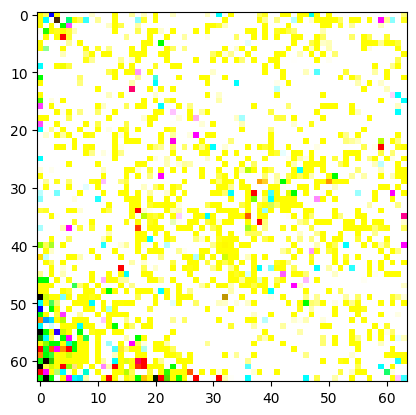

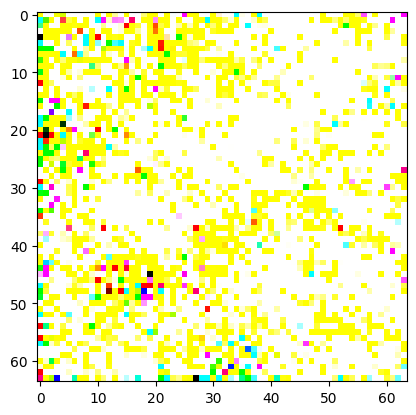


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #1
Current learning rate is 0.00029996819910385283
Train Loss is: 0.024703794475644827



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #2
Current learning rate is 0.0002999284512530315
Train Loss is: 0.01876394936814904



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #3
Current learning rate is 0.00029987281036433495
Train Loss is: 0.01617867955006659



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #4
Current learning rate is 0.00029980128253941416
Train Loss is: 0.015037725693546236



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #5
Current learning rate is 0.00029971387562209996
Train Loss is: 0.014129564119502901



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #6
Current learning rate is 0.000299610599197547
Train Loss is: 0.013626250727102161



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #7
Current learning rate is 0.0002994914645911786
Train Loss is: 0.01325767746195197



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #8
Current learning rate is 0.0002993564848674473
Train Loss is: 0.013204011698253453



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #9
Current learning rate is 0.00029920567482840066
Train Loss is: 0.012694983314722776




00%|██████████| 40/40 [00:11<00:00,  3.45it/s]]

Epoch #10
Current learning rate is 0.0002990390510120582
Train Loss is: 0.012291240231133998
Valid Loss is: 0.012132011307403445



00%|██████████| 1000/1000 [00:38<00:00, 25.75it/s]

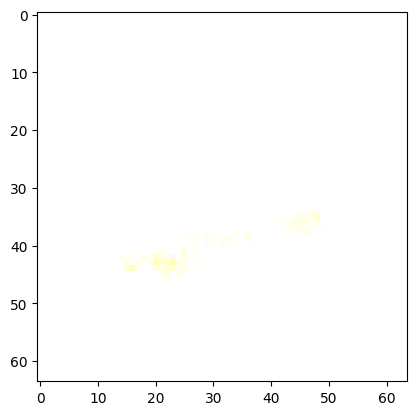

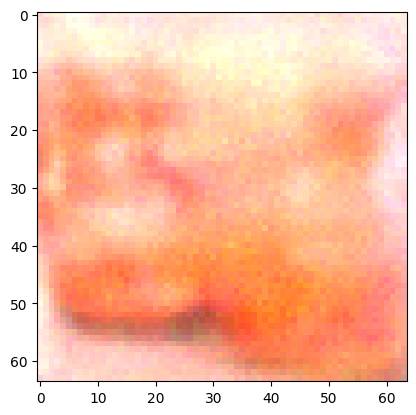


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #11
Current learning rate is 0.0002988566316905999
Train Loss is: 0.011924256850034



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #12
Current learning rate is 0.00029865843686836027
Train Loss is: 0.011980794928967952



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #13
Current learning rate is 0.0002984444882796339
Train Loss is: 0.011745951785705984



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #14
Current learning rate is 0.0002982148093862955
Train Loss is: 0.011697636973112822



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #15
Current learning rate is 0.0002979694253752237
Train Loss is: 0.011710006766952575



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #16
Current learning rate is 0.0002977083631555405
Train Loss is: 0.011649149670265615



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #17
Current learning rate is 0.00029743165135566024
Train Loss is: 0.011533506358973681



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #18
Current learning rate is 0.0002971393203201501
Train Loss is: 0.011503077633678914



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #19
Current learning rate is 0.00029683140210640227
Train Loss is: 0.011266187611036003




00%|██████████| 40/40 [00:11<00:00,  3.44it/s]]

Epoch #20
Current learning rate is 0.0002965079304811192
Train Loss is: 0.011357079679146408
Valid Loss is: 0.011129851709119976



00%|██████████| 1000/1000 [00:38<00:00, 25.70it/s]

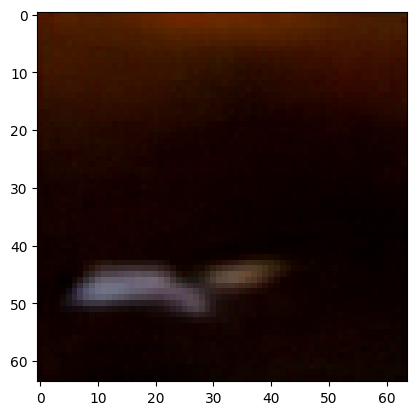

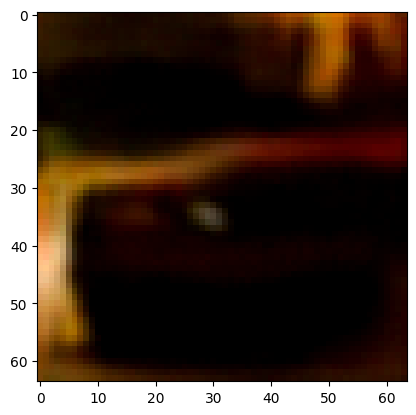


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #21
Current learning rate is 0.0002961689409166091
Train Loss is: 0.011337052462622524



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #22
Current learning rate is 0.00029581447058689783
Train Loss is: 0.011209897552616895



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #23
Current learning rate is 0.00029544455836365236
Train Loss is: 0.011366749317385256



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #24
Current learning rate is 0.0002950592448119157
Train Loss is: 0.011029514190740884



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #25
Current learning rate is 0.00029465857218566126
Train Loss is: 0.011136748264543712



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #26
Current learning rate is 0.00029424258442315766
Train Loss is: 0.011176568623632192



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #27
Current learning rate is 0.0002938113271421502
Train Loss is: 0.011176560251042246



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #28
Current learning rate is 0.0002933648476348606
Train Loss is: 0.011085530519485473



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #29
Current learning rate is 0.00029290319486279757
Train Loss is: 0.011091941995546221




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #30
Current learning rate is 0.00029242641945139027
Train Loss is: 0.011088613988831639
Valid Loss is: 0.010687178885564207



00%|██████████| 1000/1000 [00:38<00:00, 25.68it/s]

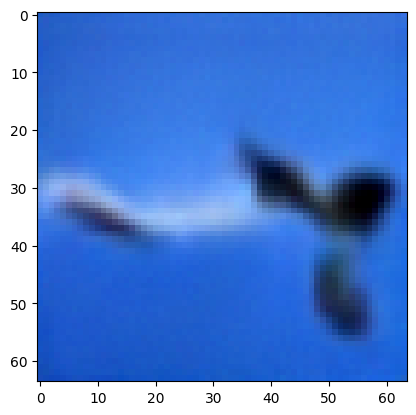

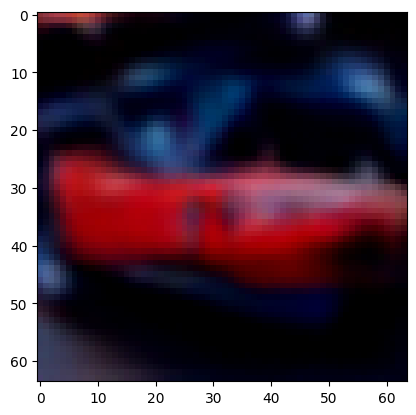


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #31
Current learning rate is 0.0002919345736844348
Train Loss is: 0.010844071037136018



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #32
Current learning rate is 0.00029142771149836253
Train Loss is: 0.010871062790974974



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #33
Current learning rate is 0.0002909058884763243
Train Loss is: 0.010799171708058566



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #34
Current learning rate is 0.00029036916184209426
Train Loss is: 0.010985053717158735



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #35
Current learning rate is 0.0002898175904537962
Train Loss is: 0.011018390061799437



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #36
Current learning rate is 0.00028925123479744914
Train Loss is: 0.010811044736765325



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #37
Current learning rate is 0.00028867015698033204
Train Loss is: 0.01080003909068182



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #38
Current learning rate is 0.00028807442072417656
Train Loss is: 0.010938054770231248



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #39
Current learning rate is 0.0002874640913581762
Train Loss is: 0.010760552533902228




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #40
Current learning rate is 0.000286839235811824
Train Loss is: 0.010724677143152804
Valid Loss is: 0.010988697269931435



00%|██████████| 1000/1000 [00:38<00:00, 25.71it/s]

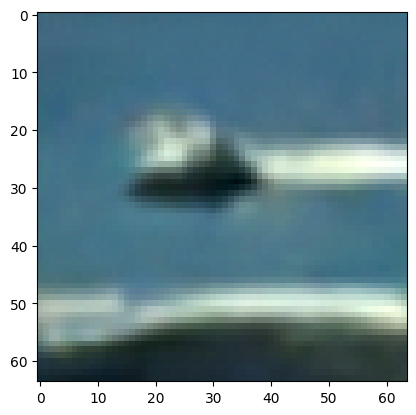

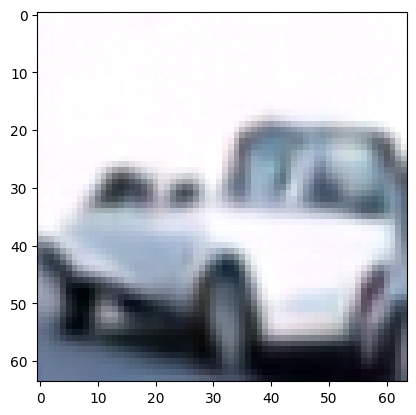


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #41
Current learning rate is 0.0002861999226075722
Train Loss is: 0.010749127087183296



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #42
Current learning rate is 0.00028554622185331775
Train Loss is: 0.011015661219134927



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #43
Current learning rate is 0.0002848782052347148
Train Loss is: 0.010717968321405352



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #44
Current learning rate is 0.00028419594600731345
Train Loss is: 0.010775145937222987



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #45
Current learning rate is 0.00028349951898852646
Train Loss is: 0.010703103593550622



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #46
Current learning rate is 0.00028278900054942404
Train Loss is: 0.0106315575260669



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #47
Current learning rate is 0.0002820644686063603
Train Loss is: 0.010560907560866327



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #48
Current learning rate is 0.0002813260026124274
Train Loss is: 0.010736710876226425



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #49
Current learning rate is 0.00028057368354874294
Train Loss is: 0.010539418032858522




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #50
Current learning rate is 0.00027980759391557094
Train Loss is: 0.010688998703844845
Valid Loss is: 0.010771140630822629



00%|██████████| 1000/1000 [00:38<00:00, 25.80it/s]

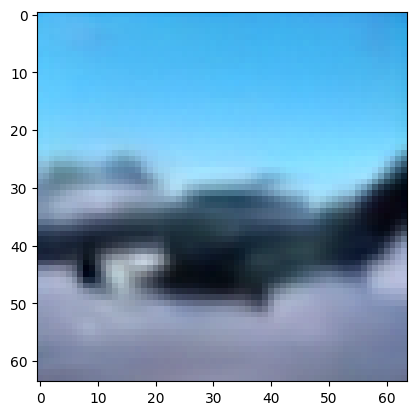

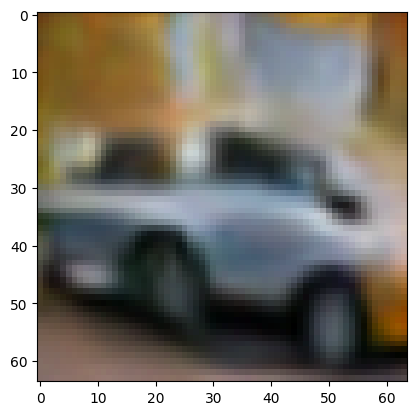


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #51
Current learning rate is 0.00027902781772327277
Train Loss is: 0.010572735730092972



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #52
Current learning rate is 0.00027823444048309475
Train Loss is: 0.01052513774484396



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #53
Current learning rate is 0.0002774275491977913
Train Loss is: 0.010615813659969718



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #54
Current learning rate is 0.0002766072323520859
Train Loss is: 0.01058089267462492



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #55
Current learning rate is 0.00027577357990296353
Train Loss is: 0.010608568114694208



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #56
Current learning rate is 0.0002749266832698103
Train Loss is: 0.010633060687687247



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #57
Current learning rate is 0.000274066635324386
Train Loss is: 0.010534647388849407



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #58
Current learning rate is 0.00027319353038063944
Train Loss is: 0.010851057479158044



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #59
Current learning rate is 0.0002723074641843665
Train Loss is: 0.01045854549156502




00%|██████████| 40/40 [00:11<00:00,  3.45it/s]]

Epoch #60
Current learning rate is 0.00027140853390271067
Train Loss is: 0.010762793878093362
Valid Loss is: 0.010839351778849959



00%|██████████| 1000/1000 [00:39<00:00, 25.58it/s]

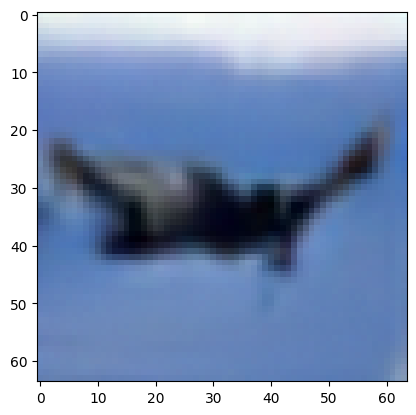

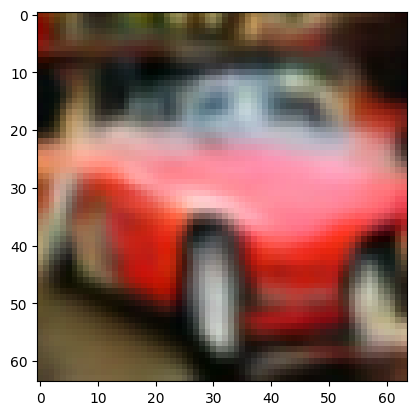


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #61
Current learning rate is 0.0002704968381135077
Train Loss is: 0.010392307864967733



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #62
Current learning rate is 0.00026957247679447477
Train Loss is: 0.010484023750759661



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #63
Current learning rate is 0.0002686355513122463
Train Loss is: 0.01063754094298929



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #64
Current learning rate is 0.0002676861644112604
Train Loss is: 0.010513125963043421



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #65
Current learning rate is 0.0002667244202024886
Train Loss is: 0.010663422460202127



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #66
Current learning rate is 0.0002657504241520221
Train Loss is: 0.010498090903274715



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #67
Current learning rate is 0.00026476428306950334
Train Loss is: 0.010659532696008682



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #68
Current learning rate is 0.0002637661050964153
Train Loss is: 0.01042180258082226



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #69
Current learning rate is 0.00026275599969422046
Train Loss is: 0.010507948868907989




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #70
Current learning rate is 0.00026173407763235943
Train Loss is: 0.010464901044033468
Valid Loss is: 0.010660931037273258



00%|██████████| 1000/1000 [00:38<00:00, 25.66it/s]

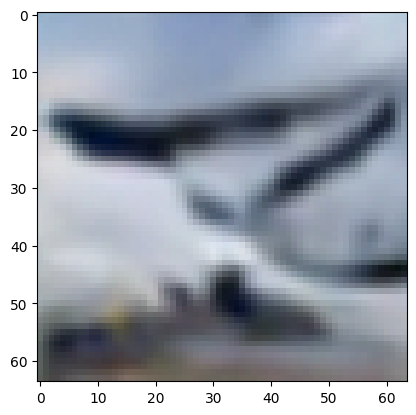

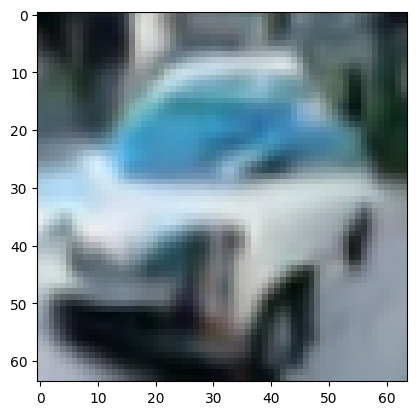


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #71
Current learning rate is 0.00026070045097610243
Train Loss is: 0.010408698306418955



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #72
Current learning rate is 0.0002596552330742604
Train Loss is: 0.010535377233754844



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #73
Current learning rate is 0.0002585985385467544
Train Loss is: 0.01061777057358995



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #74
Current learning rate is 0.00025753048327204734
Train Loss is: 0.010612327009439468



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #75
Current learning rate is 0.00025645118437443617
Train Loss is: 0.010526393952313811



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #76
Current learning rate is 0.00025536076021120746
Train Loss is: 0.010591404272709042



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #77
Current learning rate is 0.0002542593303596584
Train Loss is: 0.010460579700302333



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #78
Current learning rate is 0.0002531470156039863
Train Loss is: 0.010527086667716503



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #79
Current learning rate is 0.00025202393792203754
Train Loss is: 0.010559578286483884




00%|██████████| 40/40 [00:11<00:00,  3.47it/s]]

Epoch #80
Current learning rate is 0.0002508902204719355
Train Loss is: 0.01060436802683398
Valid Loss is: 0.010384338512085377



00%|██████████| 1000/1000 [00:38<00:00, 25.80it/s]

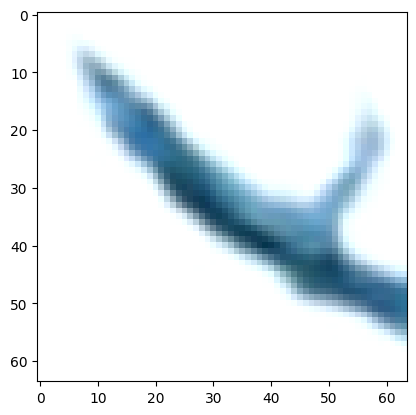

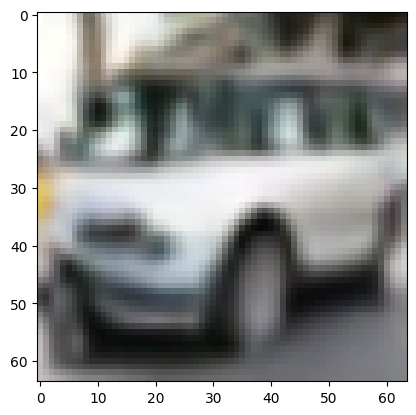


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #81
Current learning rate is 0.0002497459875785741
Train Loss is: 0.010519102637190372



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #82
Current learning rate is 0.00024859136471998424
Train Loss is: 0.010545791466720402



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #83
Current learning rate is 0.00024742647851357384
Train Loss is: 0.010459218490868807



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #84
Current learning rate is 0.0002462514567022427
Train Loss is: 0.01044294509338215



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #85
Current learning rate is 0.000245066428140374
Train Loss is: 0.010482592082116753



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #86
Current learning rate is 0.00024387152277970277
Train Loss is: 0.010519215331878513



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #87
Current learning rate is 0.0002426668716550656
Train Loss is: 0.010409214498940856



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #88
Current learning rate is 0.00024145260687003536
Train Loss is: 0.010521304842550308



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #89
Current learning rate is 0.00024022886158242971
Train Loss is: 0.010402179178781808




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #90
Current learning rate is 0.00023899576998970924
Train Loss is: 0.01047116726404056
Valid Loss is: 0.01001965212635696



00%|██████████| 1000/1000 [00:38<00:00, 25.73it/s]

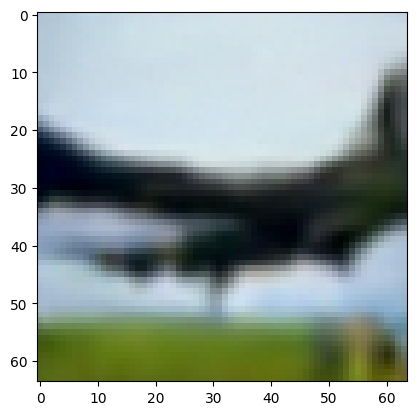

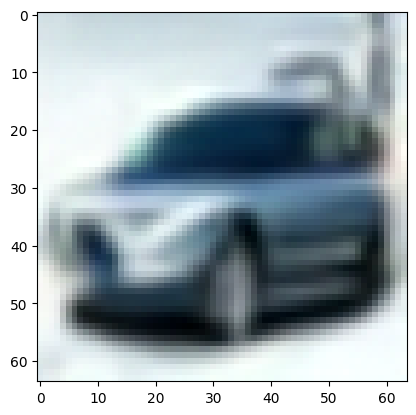


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #91
Current learning rate is 0.00023775346731426327
Train Loss is: 0.010369366586674004



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #92
Current learning rate is 0.0002365020897885795
Train Loss is: 0.010389322275295853



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #93
Current learning rate is 0.00023524177464030526
Train Loss is: 0.010474018477834761



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #94
Current learning rate is 0.00023397266007719897
Train Loss is: 0.010508709829300642



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #95
Current learning rate is 0.00023269488527197476
Train Loss is: 0.01051518802996725



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #96
Current learning rate is 0.00023140859034703848
Train Loss is: 0.010342750465497375



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #97
Current learning rate is 0.00023011391635912413
Train Loss is: 0.010510314046405256



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #98
Current learning rate is 0.00022881100528382404
Train Loss is: 0.010580681231804192



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #99
Current learning rate is 0.00022750000000002006
Train Loss is: 0.010422438853420318




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #100
Current learning rate is 0.00022618104427421542
Train Loss is: 0.010460570666473358
Valid Loss is: 0.010730043798685075



00%|██████████| 1000/1000 [00:38<00:00, 25.75it/s]

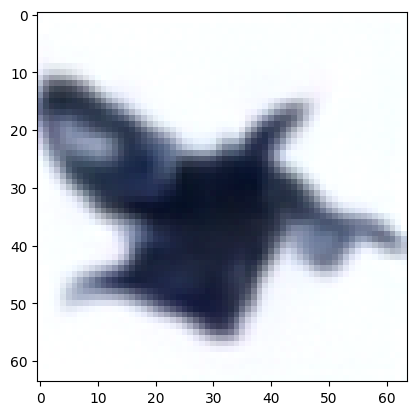

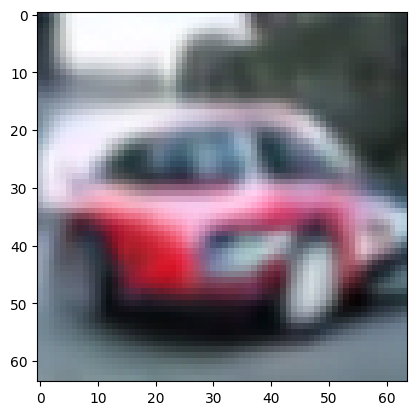


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #101
Current learning rate is 0.00022485428274476868
Train Loss is: 0.010547246225178242



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #102
Current learning rate is 0.0002235198609060324
Train Loss is: 0.010429066035430878



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #103
Current learning rate is 0.00022217792509239922
Train Loss is: 0.010403128175530582



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #104
Current learning rate is 0.00022082862246225346
Train Loss is: 0.010507762851193547



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #105
Current learning rate is 0.00021947210098183361
Train Loss is: 0.010574495177716017



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #106
Current learning rate is 0.00021810850940900636
Train Loss is: 0.010389818963594734



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #107
Current learning rate is 0.00021673799727695432
Train Loss is: 0.010560408269520849



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #108
Current learning rate is 0.00021536071487777685
Train Loss is: 0.010534145946148783



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #109
Current learning rate is 0.00021397681324600957
Train Loss is: 0.010344265846069902




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #110
Current learning rate is 0.0002125864441420615
Train Loss is: 0.01047630480490625
Valid Loss is: 0.010493563022464514



00%|██████████| 1000/1000 [00:38<00:00, 25.75it/s]

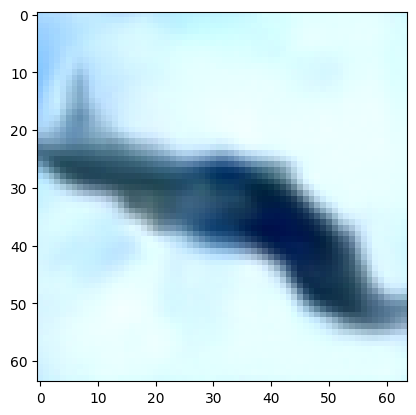

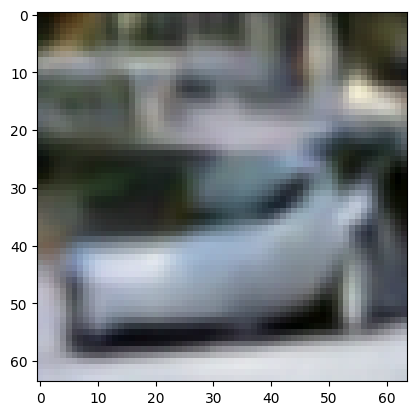


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #111
Current learning rate is 0.0002111897600355731
Train Loss is: 0.010696015518624336



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #112
Current learning rate is 0.00020978691408869571
Train Loss is: 0.010417348006740212



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #113
Current learning rate is 0.00020837806013929624
Train Loss is: 0.010367813461925834



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #114
Current learning rate is 0.00020696335268408607
Train Loss is: 0.010517340111546218



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #115
Current learning rate is 0.0002055429468616809
Train Loss is: 0.010386008145287633



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #116
Current learning rate is 0.00020411699843558473
Train Loss is: 0.01055171401007101



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #117
Current learning rate is 0.00020268566377711213
Train Loss is: 0.010621349052526057



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #118
Current learning rate is 0.0002012490998482379
Train Loss is: 0.010523356525227427



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #119
Current learning rate is 0.00019980746418438516
Train Loss is: 0.010457501080818474




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #120
Current learning rate is 0.00019836091487715027
Train Loss is: 0.010526425712741911
Valid Loss is: 0.010511709959246218



00%|██████████| 1000/1000 [00:38<00:00, 25.68it/s]

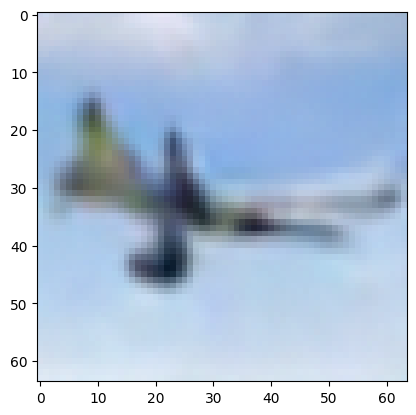

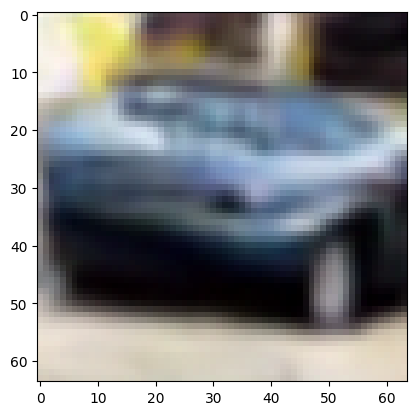


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #121
Current learning rate is 0.00019690961055696612
Train Loss is: 0.01056715394835919



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #122
Current learning rate is 0.00019545371037570585
Train Loss is: 0.010392735514324158



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #123
Current learning rate is 0.0001939933739892309
Train Loss is: 0.01042836585547775



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #124
Current learning rate is 0.00019252876153988288
Train Loss is: 0.01030303023988381



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #125
Current learning rate is 0.00019106003363892132
Train Loss is: 0.01038202441064641



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #126
Current learning rate is 0.00018958735134891138
Train Loss is: 0.010496190772391856



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #127
Current learning rate is 0.00018811087616606192
Train Loss is: 0.010425798122305423



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #128
Current learning rate is 0.00018663077000251527
Train Loss is: 0.010391139683779329



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #129
Current learning rate is 0.0001851471951685917
Train Loss is: 0.010401655081659555




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #130
Current learning rate is 0.00018366031435498983
Train Loss is: 0.010659510055556893
Valid Loss is: 0.010836442024447024



00%|██████████| 1000/1000 [00:39<00:00, 25.60it/s]

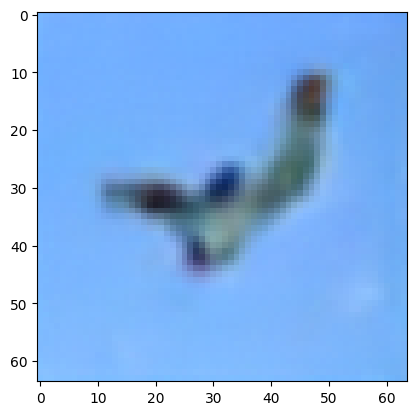

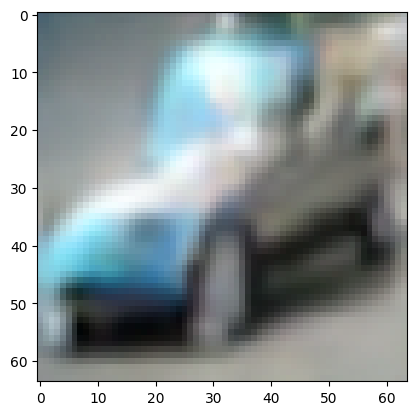


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #131
Current learning rate is 0.00018217029061494639
Train Loss is: 0.0103563870373182



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #132
Current learning rate is 0.0001806772873463556
Train Loss is: 0.010470231587532908



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #133
Current learning rate is 0.0001791814682738507
Train Loss is: 0.010483171506784857



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #134
Current learning rate is 0.0001776829974308491
Train Loss is: 0.010608150474727154



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #135
Current learning rate is 0.0001761820391415651
Train Loss is: 0.010425290467683226



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #136
Current learning rate is 0.00017467875800298945
Train Loss is: 0.010474116052500903



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #137
Current learning rate is 0.0001731733188668392
Train Loss is: 0.010460725787561386



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #138
Current learning rate is 0.00017166588682148063
Train Loss is: 0.010471273954026401



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #139
Current learning rate is 0.0001701566271738246
Train Loss is: 0.010448549233842641




00%|██████████| 40/40 [00:11<00:00,  3.45it/s]]

Epoch #140
Current learning rate is 0.00016864570543119898
Train Loss is: 0.010328909712843597
Valid Loss is: 0.010599509556777775



00%|██████████| 1000/1000 [00:38<00:00, 25.72it/s]

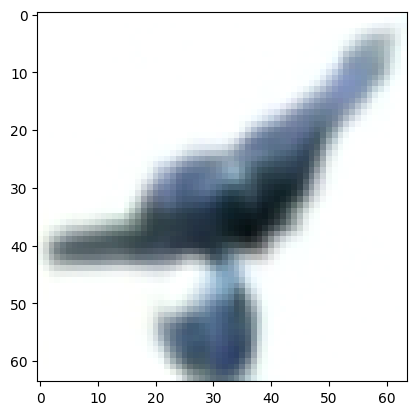

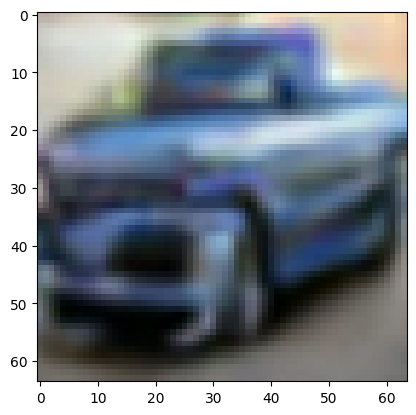


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #141
Current learning rate is 0.00016713328728320027
Train Loss is: 0.010439293019007891



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #142
Current learning rate is 0.0001656195385835209
Train Loss is: 0.010412479708902538



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #143
Current learning rate is 0.0001641046253317647
Train Loss is: 0.010423094350844622



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #144
Current learning rate is 0.00016258871365524088
Train Loss is: 0.010456270910799504



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #145
Current learning rate is 0.00016107196979074764
Train Loss is: 0.010572740652132779



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #146
Current learning rate is 0.00015955456006634222
Train Loss is: 0.010561061082407832



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #147
Current learning rate is 0.00015803665088310036
Train Loss is: 0.01035851649241522



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #148
Current learning rate is 0.00015651840869686904
Train Loss is: 0.010385285359807312



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #149
Current learning rate is 0.0001550000000000133
Train Loss is: 0.010436810716055334




00%|██████████| 40/40 [00:11<00:00,  3.45it/s]]

Epoch #150
Current learning rate is 0.00015348159130315755
Train Loss is: 0.010369332286063581
Valid Loss is: 0.010509134456515312



00%|██████████| 1000/1000 [00:38<00:00, 25.73it/s]

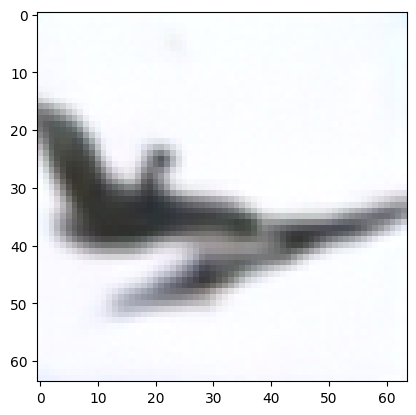

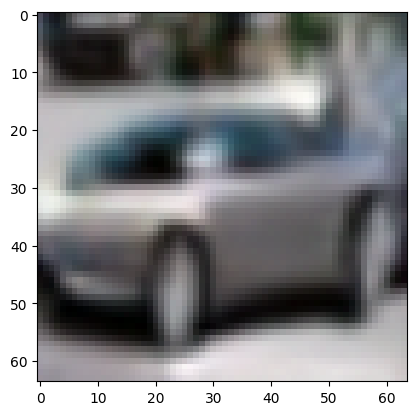


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #151
Current learning rate is 0.00015196334911692617
Train Loss is: 0.010429404540918768



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #152
Current learning rate is 0.00015044543993368418
Train Loss is: 0.010480916420929133



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #153
Current learning rate is 0.0001489280302092787
Train Loss is: 0.010420077932067215



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #154
Current learning rate is 0.00014741128634478573
Train Loss is: 0.010362411893438547



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #155
Current learning rate is 0.00014589537466826213
Train Loss is: 0.010491835791617632



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #156
Current learning rate is 0.00014438046141650588
Train Loss is: 0.010489321472123265



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #157
Current learning rate is 0.0001428667127168267
Train Loss is: 0.010527111513074488



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #158
Current learning rate is 0.00014135429456882758
Train Loss is: 0.010604440371971578



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #159
Current learning rate is 0.00013984337282620235
Train Loss is: 0.010520857165101916




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #160
Current learning rate is 0.00013833411317854617
Train Loss is: 0.010491170473396778
Valid Loss is: 0.01055760495364666



00%|██████████| 1000/1000 [00:38<00:00, 25.69it/s]

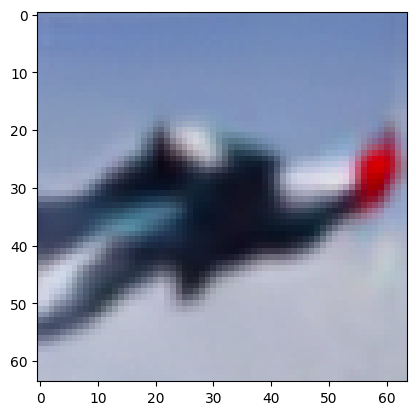

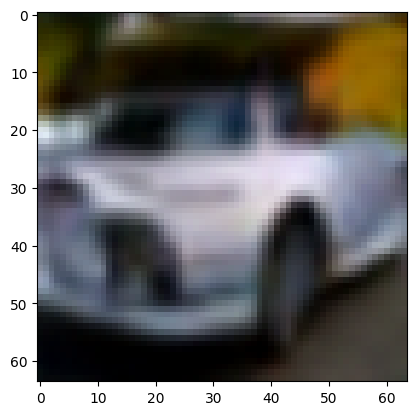


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #161
Current learning rate is 0.00013682668113318766
Train Loss is: 0.010550104780122638



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #162
Current learning rate is 0.00013532124199703755
Train Loss is: 0.010470181098207831



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #163
Current learning rate is 0.00013381796085846197
Train Loss is: 0.010329867135733367



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #164
Current learning rate is 0.00013231700256917788
Train Loss is: 0.010498135576490313



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #165
Current learning rate is 0.00013081853172617773
Train Loss is: 0.010396524465177208



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #166
Current learning rate is 0.00012932271265367405
Train Loss is: 0.0103974121902138



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #167
Current learning rate is 0.00012782970938508478
Train Loss is: 0.010518466848880052



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #168
Current learning rate is 0.000126339685645043
Train Loss is: 0.01014238440664485



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #169
Current learning rate is 0.0001248528048314423
Train Loss is: 0.010519211627542973




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #170
Current learning rate is 0.00012336922999751988
Train Loss is: 0.010508952003438026
Valid Loss is: 0.010281956125982105



00%|██████████| 1000/1000 [00:38<00:00, 25.84it/s]

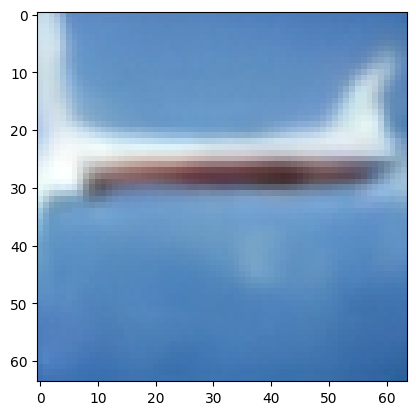

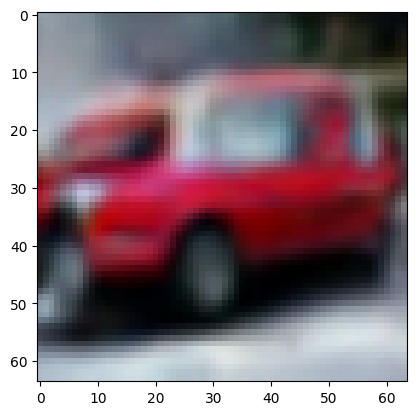


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #171
Current learning rate is 0.00012188912383397446
Train Loss is: 0.01035146317910403



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #172
Current learning rate is 0.00012041264865112507
Train Loss is: 0.010499638970941305



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #173
Current learning rate is 0.00011893996636111505
Train Loss is: 0.010525106161367148



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #174
Current learning rate is 0.00011747123846015324
Train Loss is: 0.01037025194382295



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #175
Current learning rate is 0.000116006626010805
Train Loss is: 0.010333135433029383



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #176
Current learning rate is 0.00011454628962433008
Train Loss is: 0.010410556711722165



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #177
Current learning rate is 0.00011309038944306971
Train Loss is: 0.010455326139926911



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #178
Current learning rate is 0.00011163908512288526
Train Loss is: 0.010444745626300574



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #179
Current learning rate is 0.00011019253581565029
Train Loss is: 0.010424588930327446




00%|██████████| 40/40 [00:11<00:00,  3.44it/s]]

Epoch #180
Current learning rate is 0.0001087509001517973
Train Loss is: 0.01032444205833599
Valid Loss is: 0.01037929286248982



00%|██████████| 1000/1000 [00:38<00:00, 25.71it/s]

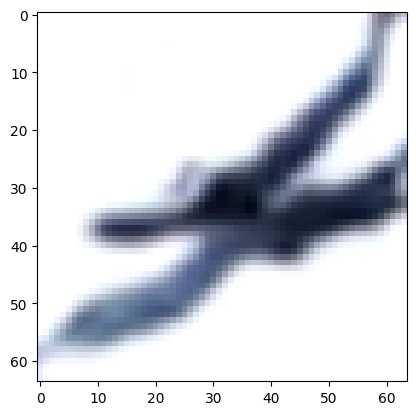

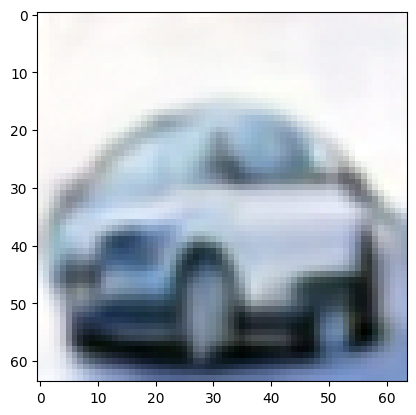


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #181
Current learning rate is 0.00010731433622292272
Train Loss is: 0.010416155778802932



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #182
Current learning rate is 0.00010588300156444974
Train Loss is: 0.010506057830061763



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #183
Current learning rate is 0.00010445705313835361
Train Loss is: 0.010475260389503091



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #184
Current learning rate is 0.0001030366473159481
Train Loss is: 0.01053083598613739



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #185
Current learning rate is 0.00010162193986073807
Train Loss is: 0.010444642438087612



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #186
Current learning rate is 0.00010021308591133836
Train Loss is: 0.010331583870574833



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #187
Current learning rate is 9.8810239964461e-05
Train Loss is: 0.010611394136212766



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #188
Current learning rate is 9.741355585797244e-05
Train Loss is: 0.010502854250371457



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #189
Current learning rate is 9.602318675402441e-05
Train Loss is: 0.010657062465324997




00%|██████████| 40/40 [00:11<00:00,  3.45it/s]]

Epoch #190
Current learning rate is 9.4639285122257e-05
Train Loss is: 0.010474339409265667
Valid Loss is: 0.010480183514300734



00%|██████████| 1000/1000 [00:38<00:00, 25.78it/s]

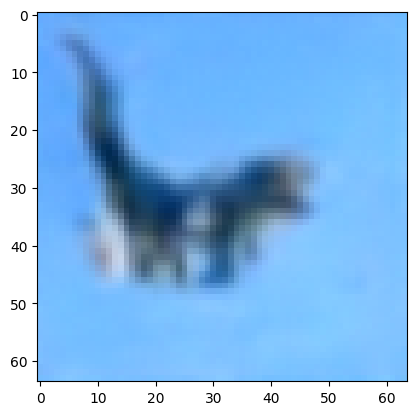

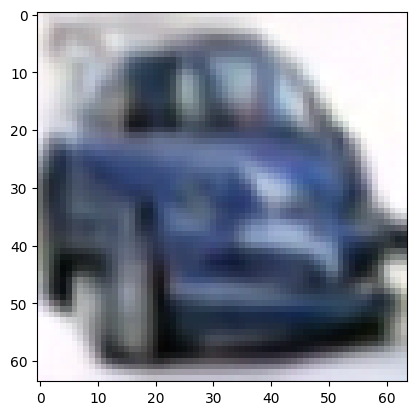


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #191
Current learning rate is 9.326200272307933e-05
Train Loss is: 0.010455752643756568



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #192
Current learning rate is 9.189149059102721e-05
Train Loss is: 0.010455746361985803



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #193
Current learning rate is 9.052789901819995e-05
Train Loss is: 0.010473758596926928



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #194
Current learning rate is 8.917137753777993e-05
Train Loss is: 0.010432580220513046



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #195
Current learning rate is 8.78220749076341e-05
Train Loss is: 0.010405091028660536



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #196
Current learning rate is 8.648013909400094e-05
Train Loss is: 0.010389582959469408



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #197
Current learning rate is 8.514571725526486e-05
Train Loss is: 0.010545232750009745



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #198
Current learning rate is 8.381895572581787e-05
Train Loss is: 0.01061986856162548



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #199
Current learning rate is 8.250000000001308e-05
Train Loss is: 0.010355066489428282




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #200
Current learning rate is 8.118899471620895e-05
Train Loss is: 0.01048939092317596
Valid Loss is: 0.01050974455429241



00%|██████████| 1000/1000 [00:38<00:00, 25.72it/s]

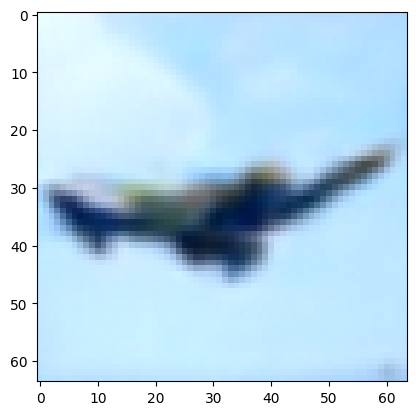

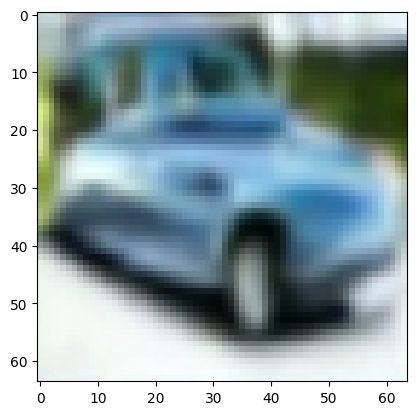


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #201
Current learning rate is 7.988608364090865e-05
Train Loss is: 0.010414043799974024



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #202
Current learning rate is 7.859140965299393e-05
Train Loss is: 0.010412273495458067



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #203
Current learning rate is 7.73051147280575e-05
Train Loss is: 0.010437991633079947



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #204
Current learning rate is 7.602733992283276e-05
Train Loss is: 0.01042904022615403



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #205
Current learning rate is 7.475822535972667e-05
Train Loss is: 0.010401309845037758



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #206
Current learning rate is 7.349791021145233e-05
Train Loss is: 0.010241891925688832



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #207
Current learning rate is 7.224653268576843e-05
Train Loss is: 0.010361722484230996



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #208
Current learning rate is 7.100423001032253e-05
Train Loss is: 0.010314018540084362



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #209
Current learning rate is 6.977113841760287e-05
Train Loss is: 0.010482353009283542




00%|██████████| 40/40 [00:11<00:00,  3.47it/s]]

Epoch #210
Current learning rate is 6.854739312999761e-05
Train Loss is: 0.010430451075080782
Valid Loss is: 0.01057300940155983



00%|██████████| 1000/1000 [00:38<00:00, 25.66it/s]

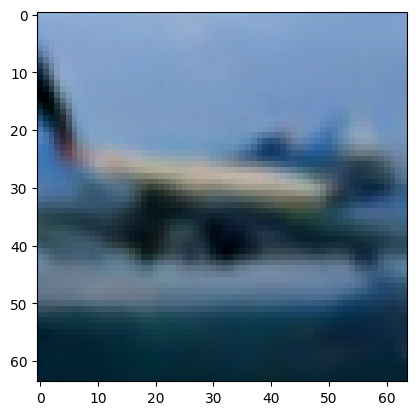

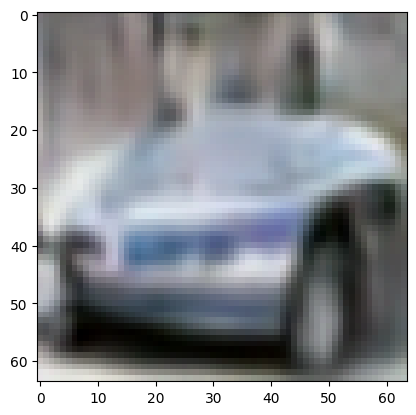


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #211
Current learning rate is 6.733312834496794e-05
Train Loss is: 0.010523974061943591



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #212
Current learning rate is 6.612847722033108e-05
Train Loss is: 0.010366981241386384



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #213
Current learning rate is 6.493357185965811e-05
Train Loss is: 0.010531880124472082



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #214
Current learning rate is 6.374854329778706e-05
Train Loss is: 0.010337992855347693



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #215
Current learning rate is 6.257352148645387e-05
Train Loss is: 0.010447636665776371



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #216
Current learning rate is 6.140863528004144e-05
Train Loss is: 0.010189741861540823



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #217
Current learning rate is 6.025401242144882e-05
Train Loss is: 0.010476755434647203



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #218
Current learning rate is 5.91097795280843e-05
Train Loss is: 0.010292141584213823



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #219
Current learning rate is 5.797606207797908e-05
Train Loss is: 0.010383812275249512




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #220
Current learning rate is 5.685298439602738e-05
Train Loss is: 0.010522482085507363
Valid Loss is: 0.01042257584631443



00%|██████████| 1000/1000 [00:38<00:00, 25.75it/s]

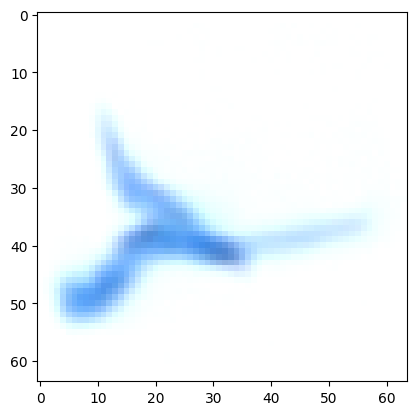

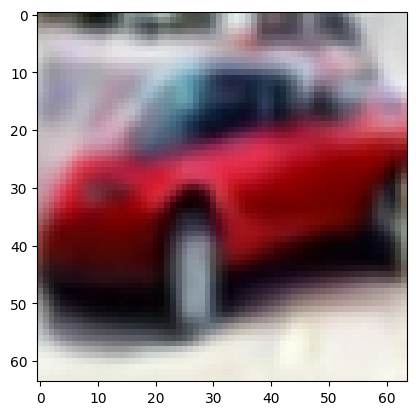


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #221
Current learning rate is 5.574066964035294e-05
Train Loss is: 0.010430507787968963



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #222
Current learning rate is 5.463923978880351e-05
Train Loss is: 0.010474289734847844



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #223
Current learning rate is 5.354881562557426e-05
Train Loss is: 0.010407959294971078



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #224
Current learning rate is 5.246951672796255e-05
Train Loss is: 0.01032833222532645



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #225
Current learning rate is 5.140146145325511e-05
Train Loss is: 0.010427355805877597



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #226
Current learning rate is 5.034476692574879e-05
Train Loss is: 0.010296061725821346



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #227
Current learning rate is 4.929954902390638e-05
Train Loss is: 0.01041005772538483



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #228
Current learning rate is 4.8265922367649306e-05
Train Loss is: 0.01042317992541939



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #229
Current learning rate is 4.7244000305788344e-05
Train Loss is: 0.010226537613198161




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #230
Current learning rate is 4.623389490359367e-05
Train Loss is: 0.010369137655943632
Valid Loss is: 0.01083274221746251



00%|██████████| 1000/1000 [00:39<00:00, 25.64it/s]

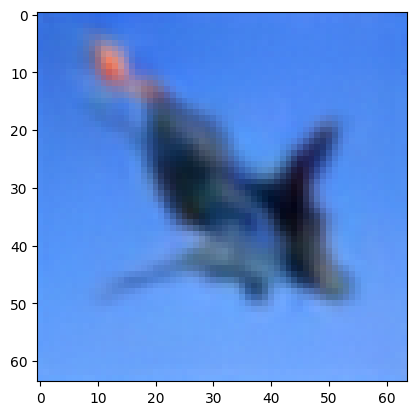

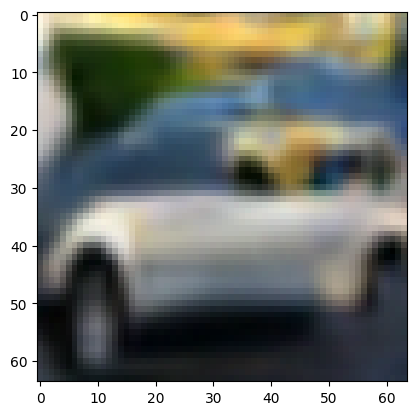


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #231
Current learning rate is 4.523571693050536e-05
Train Loss is: 0.01050251884618774



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #232
Current learning rate is 4.424957584798667e-05
Train Loss is: 0.010526473640929908



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #233
Current learning rate is 4.327557979752003e-05
Train Loss is: 0.010348491524346172



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #234
Current learning rate is 4.2313835588748434e-05
Train Loss is: 0.010456529452931136



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #235
Current learning rate is 4.136444868776218e-05
Train Loss is: 0.010425254828296602



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #236
Current learning rate is 4.0427523205533603e-05
Train Loss is: 0.010517777097411453



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #237
Current learning rate is 3.950316188650032e-05
Train Loss is: 0.010350698730908334



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #238
Current learning rate is 3.85914660972972e-05
Train Loss is: 0.010340604549273848



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #239
Current learning rate is 3.769253581564154e-05
Train Loss is: 0.010479466423857957




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #240
Current learning rate is 3.680646961936858e-05
Train Loss is: 0.010492729605175555
Valid Loss is: 0.010274932347238063



00%|██████████| 1000/1000 [00:38<00:00, 25.76it/s]

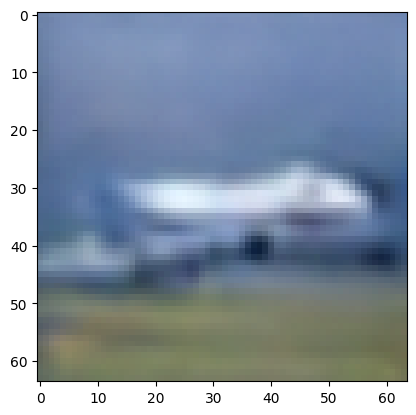

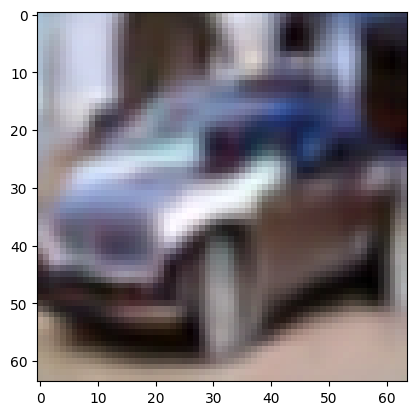


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #241
Current learning rate is 3.593336467562191e-05
Train Loss is: 0.010419391756877304



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #242
Current learning rate is 3.507331673019757e-05
Train Loss is: 0.010501561246346682



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #243
Current learning rate is 3.422642009704466e-05
Train Loss is: 0.010446088314056396



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #244
Current learning rate is 3.339276764792261e-05
Train Loss is: 0.010515813601668924



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #245
Current learning rate is 3.257245080221694e-05
Train Loss is: 0.010325794203672557



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #246
Current learning rate is 3.17655595169138e-05
Train Loss is: 0.010312943868339062



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #247
Current learning rate is 3.097218227673563e-05
Train Loss is: 0.010375432688742876



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #248
Current learning rate is 3.019240608443726e-05
Train Loss is: 0.010409528149757534



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #249
Current learning rate is 2.94263164512655e-05
Train Loss is: 0.01047302314080298




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #250
Current learning rate is 2.8673997387581584e-05
Train Loss is: 0.010410665061790496
Valid Loss is: 0.010374610358849169



00%|██████████| 1000/1000 [00:38<00:00, 25.73it/s]

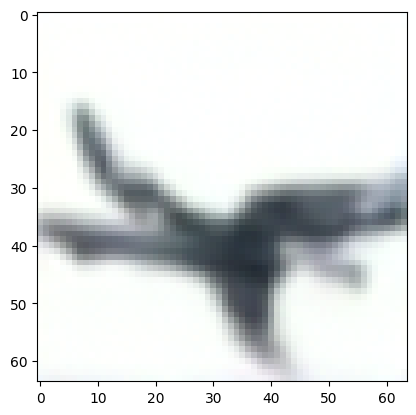

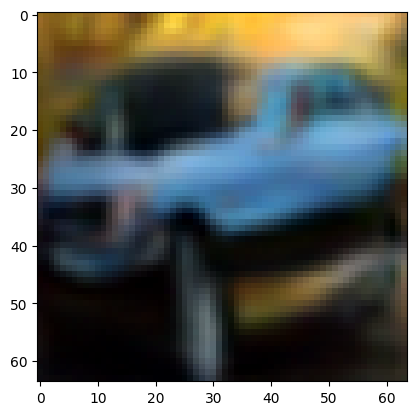


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #251
Current learning rate is 2.7935531393648813e-05
Train Loss is: 0.01033676092280075



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #252
Current learning rate is 2.7210999450585117e-05
Train Loss is: 0.010364809830207378



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #253
Current learning rate is 2.65004810114828e-05
Train Loss is: 0.010497532358858735



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #254
Current learning rate is 2.5804053992695486e-05
Train Loss is: 0.01051230969140306



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #255
Current learning rate is 2.5121794765293845e-05
Train Loss is: 0.010422389484010636



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #256
Current learning rate is 2.445377814669029e-05
Train Loss is: 0.010336707348469644



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #257
Current learning rate is 2.3800077392435162e-05
Train Loss is: 0.010509599659126252



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #258
Current learning rate is 2.316076418818273e-05
Train Loss is: 0.01048508046194911



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #259
Current learning rate is 2.2535908641830123e-05
Train Loss is: 0.01042767456965521




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #260
Current learning rate is 2.1925579275829637e-05
Train Loss is: 0.010398480056319387
Valid Loss is: 0.010562271368689835



00%|██████████| 1000/1000 [00:38<00:00, 25.84it/s]

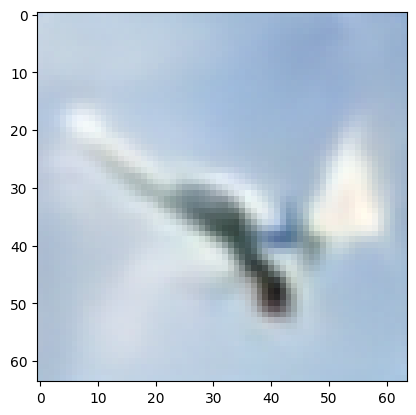

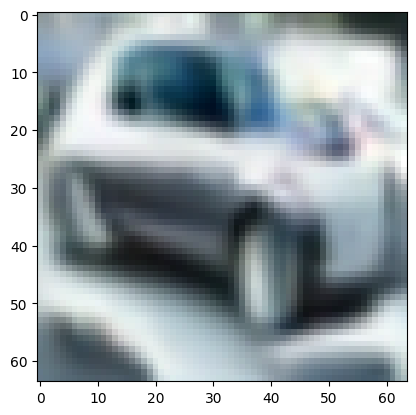


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #261
Current learning rate is 2.1329843019673988e-05
Train Loss is: 0.010511912787333131



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #262
Current learning rate is 2.0748765202556997e-05
Train Loss is: 0.010319880850147456



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #263
Current learning rate is 2.0182409546209423e-05
Train Loss is: 0.010356162895914168



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #264
Current learning rate is 1.9630838157911315e-05
Train Loss is: 0.010507826039101928



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #265
Current learning rate is 1.9094111523680994e-05
Train Loss is: 0.010447062798775733



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #266
Current learning rate is 1.857228850164228e-05
Train Loss is: 0.010325757849495859



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #267
Current learning rate is 1.8065426315569893e-05
Train Loss is: 0.010579087706282735



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #268
Current learning rate is 1.7573580548614423e-05
Train Loss is: 0.010419565960764885



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #269
Current learning rate is 1.7096805137206824e-05
Train Loss is: 0.010402052942663432




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #270
Current learning rate is 1.6635152365143664e-05
Train Loss is: 0.010367619039025158
Valid Loss is: 0.010041713539976627



00%|██████████| 1000/1000 [00:38<00:00, 25.75it/s]

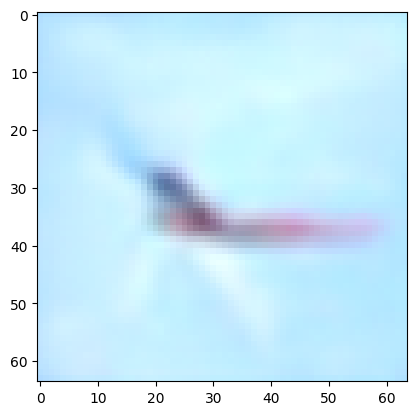

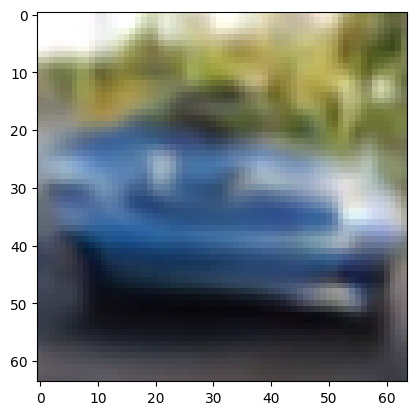


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #271
Current learning rate is 1.6188672857853803e-05
Train Loss is: 0.010357421198859811



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #272
Current learning rate is 1.575741557684654e-05
Train Loss is: 0.010484219987411052



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #273
Current learning rate is 1.5341427814342608e-05
Train Loss is: 0.010339344732929022



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #274
Current learning rate is 1.4940755188087913e-05
Train Loss is: 0.010338931500446052



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #275
Current learning rate is 1.4555441636351084e-05
Train Loss is: 0.010444499489385634



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #276
Current learning rate is 1.4185529413105135e-05
Train Loss is: 0.010294931950047612



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #277
Current learning rate is 1.383105908339391e-05
Train Loss is: 0.010372220419812948



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #278
Current learning rate is 1.34920695188836e-05
Train Loss is: 0.010266240378841758



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #279
Current learning rate is 1.316859789359998e-05
Train Loss is: 0.010473063732497394




00%|██████████| 40/40 [00:11<00:00,  3.45it/s]]

Epoch #280
Current learning rate is 1.286067967985197e-05
Train Loss is: 0.010324041603598743
Valid Loss is: 0.010445015970617533



00%|██████████| 1000/1000 [00:38<00:00, 25.65it/s]

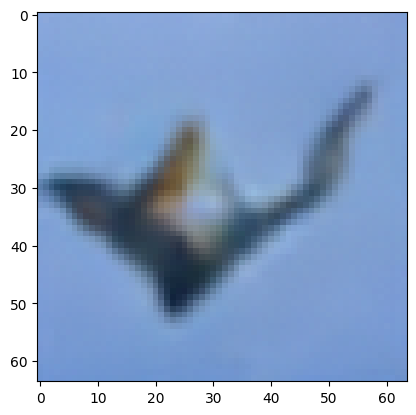

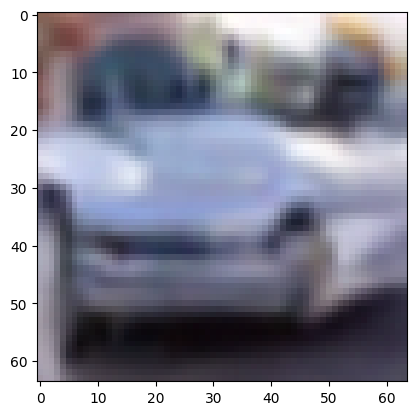


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #281
Current learning rate is 1.2568348644341586e-05
Train Loss is: 0.01031539051560685



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #282
Current learning rate is 1.2291636844461221e-05
Train Loss is: 0.010357065354473888



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #283
Current learning rate is 1.2030574624777936e-05
Train Loss is: 0.010518504690844565



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #284
Current learning rate is 1.1785190613706036e-05
Train Loss is: 0.010527750626206398



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #285
Current learning rate is 1.155551172036756e-05
Train Loss is: 0.010366730028763413



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #286
Current learning rate is 1.1341563131641431e-05
Train Loss is: 0.01029867907986045



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #287
Current learning rate is 1.1143368309401367e-05
Train Loss is: 0.010277309915982186



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #288
Current learning rate is 1.0960948987943056e-05
Train Loss is: 0.01050446977140382



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #289
Current learning rate is 1.0794325171600799e-05
Train Loss is: 0.010302713052369654




00%|██████████| 40/40 [00:11<00:00,  3.46it/s]]

Epoch #290
Current learning rate is 1.064351513255376e-05
Train Loss is: 0.010479316653218121
Valid Loss is: 0.010534206428565085



00%|██████████| 1000/1000 [00:38<00:00, 25.71it/s]

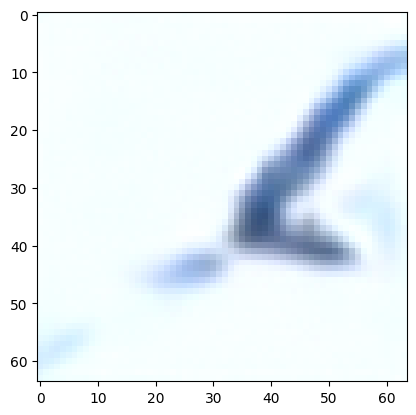

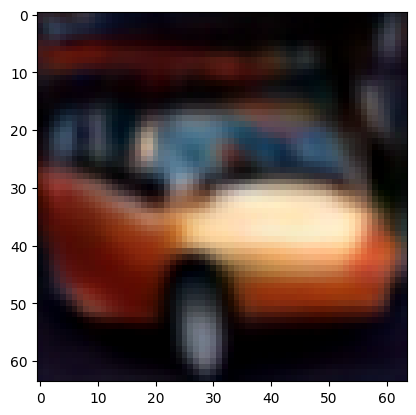


00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #291
Current learning rate is 1.050853540882216e-05
Train Loss is: 0.010342105401214212



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #292
Current learning rate is 1.03894008024538e-05
Train Loss is: 0.010477779950015247



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #293
Current learning rate is 1.028612437790078e-05
Train Loss is: 0.010437495808582753



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #294
Current learning rate is 1.0198717460586916e-05
Train Loss is: 0.010330675381701439



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #295
Current learning rate is 1.0127189635665623e-05
Train Loss is: 0.010415387242101132



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #296
Current learning rate is 1.0071548746968972e-05
Train Loss is: 0.01038887491915375



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #297
Current learning rate is 1.0031800896147429e-05
Train Loss is: 0.01045670410618186



00%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #298
Current learning rate is 1.0007950442000748e-05
Train Loss is: 0.010330428627785295


100%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Epoch #299
Current learning rate is 1e-05
Train Loss is: 0.01053086991654709


In [9]:
for epoch in range(epochs):
    train_loss_list = []
    valid_loss_list = []
    for images, label in tqdm(train_dataloader):
        # Zero out grad
        optimizer.zero_grad()

        # Preparing for forward pass
        images = images.cuda(device_id)
        label = label.cuda(device_id)
        time_step = torch.randint(1, steps, size = (images.shape[0], )).cuda(device_id)
        x_t, noise = forward_pass(images, time_step)

        # Classifier free guidance.
        if random.random() < 0.1:
            label = None

        # Forward pass
        with amp.autocast():
            predicted_noise = unet(x_t, time_step, label)
            loss = criterion(predicted_noise, noise)

        # Back propagation
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Record loss
        train_loss_list.append(loss.item())

        # Step the learning rate
        scheduler.step()

    if(epoch % 10 == 0):
        with torch.no_grad():
            for images, label in tqdm(valid_dataloader):
                # Preparing for forward pass
                images = images.cuda(device_id)
                label = label.cuda(device_id)
                time_step = torch.randint(1, steps, size = (images.shape[0], )).cuda(device_id)
                x_t, noise = forward_pass(images, time_step)

                # Forward pass
                with amp.autocast():
                    predicted_noise = unet(x_t, time_step, label)
                    loss = criterion(predicted_noise, noise)
                valid_loss_list.append(loss.item())

    print(f"Epoch #{epoch}")
    print(f"Current learning rate is {optimizer.param_groups[0]['lr']}")
    print("Train Loss is:", sum(train_loss_list)/len(train_loss_list))
    loss_train.append(sum(train_loss_list)/len(train_loss_list))
    if(epoch % 10 == 0):
        print("Valid Loss is:", sum(valid_loss_list)/len(valid_loss_list))
        loss_valid.append(sum(valid_loss_list)/len(valid_loss_list))
    if(epoch % 10 == 0):
        label = torch.tensor([0, 1]).cuda(device_id)
        sampling(unet, label)

In [11]:
torch.save(unet, "diffusion_CIFAR10.pth")